In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import joblib
from datetime import datetime
import os
import sys

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Create directories
os.makedirs('artifacts/all_best_models', exist_ok=True)

print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version}")

✅ All libraries imported successfully!
Python version: 3.9.6 (default, Oct 17 2025, 17:15:53) 
[Clang 17.0.0 (clang-1700.4.4.1)]


In [68]:
# Load and prepare dataset
def load_dataset(csv_path="Train Data.csv"):
    """
    Load dataset from CSV file instead of hardcoded dictionary.
    Ensure the CSV column names match EXACTLY as used in your project.
    """
    df = pd.read_csv(csv_path)

    # Optional: Clean column names (remove spaces, unify formatting)
    df.columns = df.columns.str.strip()

    return df


# Load dataset
df = load_dataset("Train Data.csv")
print("📊 Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Display basic info
print("\n🔍 Dataset Info:")
print(df.info())

print("\n📈 First 5 rows:")
df.head()

📊 Dataset loaded successfully!
Shape: (463, 11)

🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               463 non-null    object 
 1   Signal Strength (dBm)   463 non-null    float64
 2   SNR                     463 non-null    float64
 3   Call Duration (s)       463 non-null    float64
 4   Environment             463 non-null    object 
 5   Attenuation             463 non-null    float64
 6   Distance to Tower (km)  463 non-null    float64
 7   Tower ID                463 non-null    int64  
 8   User ID                 463 non-null    int64  
 9   Call Type               463 non-null    object 
 10  Incoming/Outgoing       463 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 39.9+ KB
None

📈 First 5 rows:


,Timestamp,Signal Strength (dBm),SNR,Call Duration (s),Environment,Attenuation,Distance to Tower (km),Tower ID,User ID,Call Type,Incoming/Outgoing
0,01-03-2024 17:46,-84.119763,25.940082,1713.800550,urban,14.690438,2.243176,5,25,data,incoming
1,01-04-2024 17:29,-87.806131,15.937354,345.371848,home,6.213698,5.002567,3,22,voice,incoming
2,01-05-2024 17:14,-116.575176,14.709384,259.285043,open,4.494415,8.705974,2,5,voice,incoming
3,01-06-2024 16:02,-82.961183,21.727165,357.974004,home,7.619957,7.427025,5,33,data,outgoing
4,01-07-2024 22:19,-85.012574,26.058158,398.006716,urban,10.655159,0.612071,5,8,voice,outgoing


In [69]:
def clean_and_preprocess(df):
    """Comprehensive data cleaning and preprocessing"""
    df_clean = df.copy()
    
    # Parse timestamp (handle multiple formats)
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
    
    # Drop irrelevant columns as specified
    columns_to_drop = ['Tower ID', 'User ID', 'Call Type', 'Incoming/Outgoing', 'Call Duration (s)']
    df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])
    
    # Handle missing values
    numeric_columns = ['Signal Strength (dBm)', 'SNR', 'Attenuation', 'Distance to Tower (km)']
    categorical_columns = ['Environment']
    
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # Outlier treatment using IQR (more robust)
    for col in numeric_columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    # Ensure categorical columns are string type
    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
    
    return df_clean

df_clean = clean_and_preprocess(df)
print("✅ Data cleaning completed!")
print(f"Cleaned dataset shape: {df_clean.shape}")
print("\nCleaned dataset info:")
print(df_clean.info())
display(df_clean.head())

✅ Data cleaning completed!
Cleaned dataset shape: (463, 6)

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               187 non-null    datetime64[ns]
 1   Signal Strength (dBm)   463 non-null    float64       
 2   SNR                     463 non-null    float64       
 3   Environment             463 non-null    object        
 4   Attenuation             463 non-null    float64       
 5   Distance to Tower (km)  463 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 21.8+ KB
None


,Timestamp,Signal Strength (dBm),SNR,Environment,Attenuation,Distance to Tower (km)
0,2024-01-03 17:46:00,-84.119763,25.940082,urban,14.690438,2.243176
1,2024-01-04 17:29:00,-87.806131,15.937354,home,6.213698,5.002567
2,2024-01-05 17:14:00,-116.575176,14.709384,open,4.494415,8.705974
3,2024-01-06 16:02:00,-82.961183,21.727165,home,7.619957,7.427025
4,2024-01-07 22:19:00,-85.012574,26.058158,urban,10.655159,0.612071


In [70]:
# Constant transmitter power
P_tx_dBm = 23

# Calculate path loss
df_clean['path_loss'] = P_tx_dBm - df_clean['Signal Strength (dBm)']

print("✅ Path Loss calculated successfully!")
print(f"Path Loss Statistics:")
print(f"   Min: {df_clean['path_loss'].min():.2f} dB")
print(f"   Max: {df_clean['path_loss'].max():.2f} dB")
print(f"   Mean: {df_clean['path_loss'].mean():.2f} dB")
print(f"   Std: {df_clean['path_loss'].std():.2f} dB")

print("\nDataset with Path Loss:")
display(df_clean[['Signal Strength (dBm)', 'path_loss']].head())

✅ Path Loss calculated successfully!
Path Loss Statistics:
   Min: 73.12 dB
   Max: 141.68 dB
   Mean: 107.96 dB
   Std: 14.35 dB

Dataset with Path Loss:


,Signal Strength (dBm),path_loss
0,-84.119763,107.119763
1,-87.806131,110.806131
2,-116.575176,139.575176
3,-82.961183,105.961183
4,-85.012574,108.012574


In [71]:
def engineer_features(df):
    """Create advanced features for better model performance"""
    df_eng = df.copy()
    
    # Time-based features
    df_eng['hour'] = df_eng['Timestamp'].dt.hour
    df_eng['day_of_week'] = df_eng['Timestamp'].dt.dayofweek
    df_eng['day_of_month'] = df_eng['Timestamp'].dt.day
    
    # Cyclical encoding for time features
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24)
    df_eng['day_sin'] = np.sin(2 * np.pi * df_eng['day_of_week'] / 7)
    df_eng['day_cos'] = np.cos(2 * np.pi * df_eng['day_of_week'] / 7)
    
    # Distance transformations
    df_eng['log_distance'] = np.log1p(df_eng['Distance to Tower (km)'])
    df_eng['distance_squared'] = df_eng['Distance to Tower (km)'] ** 2
    df_eng['inverse_distance'] = 1 / (df_eng['Distance to Tower (km)'] + 0.1)
    
    # SNR transformations
    df_eng['log_snr'] = np.log1p(df_eng['SNR'])
    df_eng['snr_squared'] = df_eng['SNR'] ** 2
    
    # Attenuation transformations
    df_eng['log_attenuation'] = np.log1p(df_eng['Attenuation'])
    df_eng['attenuation_squared'] = df_eng['Attenuation'] ** 2
    
    # Environment encoding
    environment_quality = {'open': 0, 'suburban': 1, 'urban': 2, 'home': 1.5}
    df_eng['environment_quality'] = df_eng['Environment'].map(environment_quality)
    
    # Interaction features
    df_eng['distance_attenuation'] = df_eng['Distance to Tower (km)'] * df_eng['Attenuation']
    df_eng['snr_distance'] = df_eng['SNR'] * df_eng['Distance to Tower (km)']
    df_eng['signal_quality'] = df_eng['SNR'] / (df_eng['Distance to Tower (km)'] + 1)
    
    # Signal strength based features
    df_eng['effective_strength'] = df_eng['Signal Strength (dBm)'] * df_eng['SNR'] / 20
    
    print(f"✅ Feature engineering completed! Added {len([col for col in df_eng.columns if col not in df.columns])} new features")
    return df_eng

df_engineered = engineer_features(df_clean)
print(f"Original features: {len(df_clean.columns)}")
print(f"Engineered features: {len(df_engineered.columns)}")

# Show new features
new_features = [col for col in df_engineered.columns if col not in df_clean.columns]
print(f"New features: {new_features}")
display(df_engineered[new_features].head())

✅ Feature engineering completed! Added 19 new features
Original features: 7
Engineered features: 26
New features: ['hour', 'day_of_week', 'day_of_month', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'log_distance', 'distance_squared', 'inverse_distance', 'log_snr', 'snr_squared', 'log_attenuation', 'attenuation_squared', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'effective_strength']


,hour,day_of_week,day_of_month,hour_sin,hour_cos,day_sin,day_cos,log_distance,distance_squared,inverse_distance,log_snr,snr_squared,log_attenuation,attenuation_squared,environment_quality,distance_attenuation,snr_distance,signal_quality,effective_strength
0,17.0,2.0,3.0,-0.965926,-0.258819,0.974928,-0.222521,1.176553,5.031840,0.426771,3.293615,672.887845,2.753051,215.808958,2.0,32.953242,58.188178,7.998357,-109.103677
1,17.0,3.0,4.0,-0.965926,-0.258819,0.433884,-0.900969,1.792187,25.025672,0.195980,2.829521,253.999252,1.975982,38.610044,1.5,31.084438,79.727673,2.655090,-69.969869
2,17.0,4.0,5.0,-0.965926,-0.258819,-0.433884,-0.900969,2.272742,75.793975,0.113559,2.754258,216.365986,1.703732,20.199766,0.0,39.128258,128.059510,1.515498,-85.737453
3,16.0,5.0,6.0,-0.866025,-0.500000,-0.974928,-0.222521,2.131444,55.160694,0.132855,3.123561,472.069703,2.154080,58.063752,1.5,56.593611,161.368189,2.578272,-90.125566
4,22.0,6.0,7.0,-0.500000,0.866025,-0.781831,0.623490,0.477519,0.374630,1.404355,3.297989,679.027621,2.455749,113.532410,2.0,6.521709,15.949430,16.164404,-110.763556


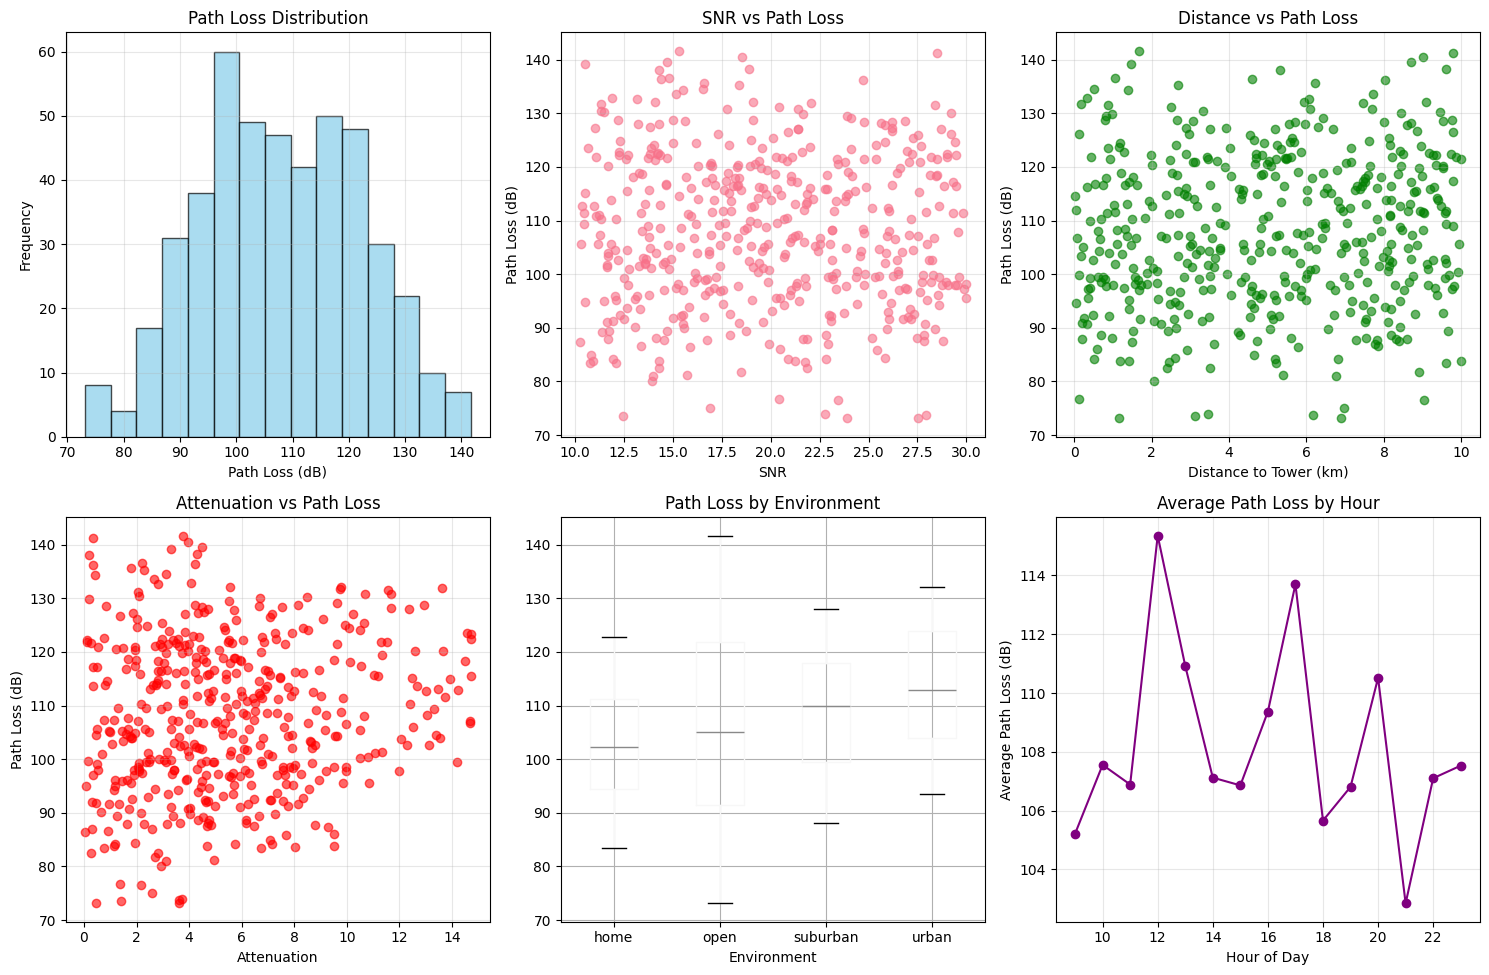

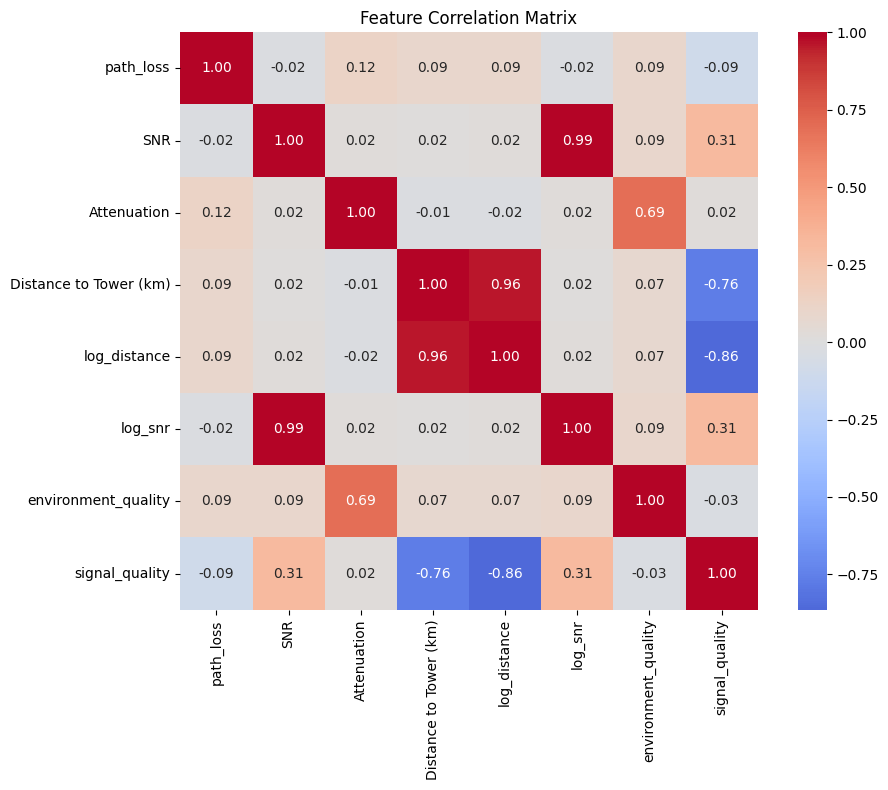

Correlation with Path Loss:
   Attenuation: 0.120
   Distance to Tower (km): 0.092
   environment_quality: 0.089
   log_distance: 0.086
   log_snr: -0.016
   SNR: -0.022
   signal_quality: -0.092


In [46]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Path Loss Distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df_engineered['path_loss'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Path Loss Distribution')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. SNR vs Path Loss
plt.subplot(2, 3, 2)
plt.scatter(df_engineered['SNR'], df_engineered['path_loss'], alpha=0.6)
plt.title('SNR vs Path Loss')
plt.xlabel('SNR')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 3. Distance vs Path Loss
plt.subplot(2, 3, 3)
plt.scatter(df_engineered['Distance to Tower (km)'], df_engineered['path_loss'], alpha=0.6, color='green')
plt.title('Distance vs Path Loss')
plt.xlabel('Distance to Tower (km)')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 4. Attenuation vs Path Loss
plt.subplot(2, 3, 4)
plt.scatter(df_engineered['Attenuation'], df_engineered['path_loss'], alpha=0.6, color='red')
plt.title('Attenuation vs Path Loss')
plt.xlabel('Attenuation')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 5. Environment vs Path Loss
plt.subplot(2, 3, 5)
df_engineered.boxplot(column='path_loss', by='Environment', ax=plt.gca())
plt.title('Path Loss by Environment')
plt.suptitle('')

# 6. Hour vs Path Loss
plt.subplot(2, 3, 6)
hourly_avg = df_engineered.groupby('hour')['path_loss'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='purple')
plt.title('Average Path Loss by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Path Loss (dB)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
numeric_columns = ['path_loss', 'SNR', 'Attenuation', 'Distance to Tower (km)', 
                  'log_distance', 'log_snr', 'environment_quality', 'signal_quality']
corr_matrix = df_engineered[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation with Path Loss:")
path_loss_corr = corr_matrix['path_loss'].sort_values(ascending=False)
for feature, corr_value in path_loss_corr.items():
    if feature != 'path_loss':
        print(f"   {feature}: {corr_value:.3f}")

In [72]:
# Select the most relevant features
selected_features = [
    # Original features
    'SNR', 'Attenuation', 'Distance to Tower (km)', 'Environment',
    
    # Engineered features
    'log_distance', 'log_snr', 'log_attenuation',
    'environment_quality', 'distance_attenuation', 'snr_distance',
    'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength'
]

X = df_engineered[selected_features]
y = df_engineered['path_loss']

print(f"Selected {len(selected_features)} features for modeling")
print(f"Features: {selected_features}")

# Train/Validation/Test split with stratification for small dataset
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print(f"Data splitting completed:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Selected 14 features for modeling
Features: ['SNR', 'Attenuation', 'Distance to Tower (km)', 'Environment', 'log_distance', 'log_snr', 'log_attenuation', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength']
Data splitting completed:
Training set: 323 samples (69.8%)
Validation set: 70 samples (15.1%)
Test set: 70 samples (15.1%)


In [74]:
# Define categorical and numerical features
categorical_features = ['Environment']
numerical_features = [col for col in selected_features if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Create robust preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense arrays if sparse and ensure no NaN values
def ensure_dense_and_clean(X):
    """Convert to dense array and handle any remaining NaN values"""
    if hasattr(X, 'toarray'):
        X_dense = X.toarray()
    else:
        X_dense = X.copy()
    
    # Replace any remaining NaN values with 0
    X_dense = np.nan_to_num(X_dense, nan=0.0)
    return X_dense

X_train_processed = ensure_dense_and_clean(X_train_processed)
X_val_processed = ensure_dense_and_clean(X_val_processed)
X_test_processed = ensure_dense_and_clean(X_test_processed)

print(f"Preprocessing completed successfully!")
print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed validation set shape: {X_val_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# Verify no NaN values
print(f"NaN values in processed data:")
print(f"  X_train: {np.isnan(X_train_processed).sum()}")
print(f"  X_val: {np.isnan(X_val_processed).sum()}")
print(f"  X_test: {np.isnan(X_test_processed).sum()}")

Categorical features: ['Environment']
Numerical features: ['SNR', 'Attenuation', 'Distance to Tower (km)', 'log_distance', 'log_snr', 'log_attenuation', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength']
Preprocessing completed successfully!
Processed training set shape: (323, 16)
Processed validation set shape: (70, 16)
Processed test set shape: (70, 16)
NaN values in processed data:
  X_train: 0
  X_val: 0
  X_test: 0


In [75]:
# Define all models with optimized parameters
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'LASSO Regression': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'max_iter': [1000, 2000]
        }
    },
    'Elastic Net': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9, -1],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'epsilon': [0.01, 0.1]
        }
    }
}

# Train and tune models with robust error handling
best_models = {}
results = []

print("Starting model training and hyperparameter tuning...")

for model_name, model_config in models.items():
    print(f"\nTraining {model_name}...")
    
    try:
        # For small dataset, use simpler approach
        if len(X_train_processed) < 50:  # Very small dataset
            print("Small dataset detected, using direct fitting...")
            model = model_config['model']
            
            # Handle models that might have issues with small data
            if model_name in ['SVR', 'LASSO', 'Elastic Net']:
                # Use default parameters for small data
                model.fit(X_train_processed, y_train)
            else:
                model.fit(X_train_processed, y_train)
                
            val_pred = model.predict(X_val_processed)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            best_models[model_name] = model
            
        elif not model_config['params']:
            # Models with no hyperparameters
            model = model_config['model']
            model.fit(X_train_processed, y_train)
            val_pred = model.predict(X_val_processed)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            best_models[model_name] = model
        else:
            # Randomized Search CV
            random_search = RandomizedSearchCV(
                estimator=model_config['model'],
                param_distributions=model_config['params'],
                n_iter=10,
                cv=min(3, len(X_train_processed)),  # Adaptive CV folds
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                random_state=42,
                verbose=0
            )
            
            random_search.fit(X_train_processed, y_train)
            best_models[model_name] = random_search.best_estimator_
            val_rmse = -random_search.best_score_
        
        # Calculate validation metrics
        val_pred = best_models[model_name].predict(X_val_processed)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_r2 = r2_score(y_val, val_pred)
        
        results.append({
            'Model': model_name,
            'Validation_RMSE': val_rmse,
            'Validation_MAE': val_mae,
            'Validation_R2': val_r2
        })
        
        # Save model
        model_filename = f'artifacts/all_best_models/{model_name.replace(" ", "_").lower()}.joblib'
        joblib.dump(best_models[model_name], model_filename)
        
        print(f"✅ {model_name} - Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}, Val R²: {val_r2:.4f}")
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)[:100]}...")
        results.append({
            'Model': model_name,
            'Validation_RMSE': np.inf,
            'Validation_MAE': np.inf,
            'Validation_R2': -np.inf
        })

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results).sort_values('Validation_RMSE')
print("\nModel Performance Ranking:")
display(results_df)

# Save preprocessor
joblib.dump(preprocessor, 'artifacts/preprocessor.joblib')
print("Preprocessor saved!")

Starting model training and hyperparameter tuning...

Training Linear Regression...
✅ Linear Regression - Val RMSE: 3.9627, Val MAE: 3.1023, Val R²: 0.9303

Training Ridge Regression...
✅ Ridge Regression - Val RMSE: 4.1458, Val MAE: 3.0929, Val R²: 0.9275

Training LASSO Regression...
✅ LASSO Regression - Val RMSE: 4.1139, Val MAE: 3.0663, Val R²: 0.9259

Training Elastic Net...
✅ Elastic Net - Val RMSE: 4.1218, Val MAE: 3.1025, Val R²: 0.9281

Training Random Forest...


/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.591e+02, tolerance: 4.224e+00
  model = cd_fast.enet_coordinate_descent(
/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.648e+01, tolerance: 4.239e+00
  model = cd_fast.enet_coordinate_descent(
/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: Con

✅ Random Forest - Val RMSE: 4.8980, Val MAE: 3.0362, Val R²: 0.9306

Training XGBoost...
❌ Error training XGBoost: 'super' object has no attribute '__sklearn_tags__'...

Training LightGBM...


/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nishantsmac/Desktop/coding/4th Year ML Project/Path_Loss_Prediction/rf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted 

✅ LightGBM - Val RMSE: 5.1711, Val MAE: 2.7727, Val R²: 0.9344

Training Gradient Boosting...
✅ Gradient Boosting - Val RMSE: 3.5246, Val MAE: 2.5474, Val R²: 0.9527

Training SVR...
✅ SVR - Val RMSE: 4.1905, Val MAE: 3.0675, Val R²: 0.9273

Model Performance Ranking:


,Model,Validation_RMSE,Validation_MAE,Validation_R2
7,Gradient Boosting,3.524607,2.547373,0.952664
0,Linear Regression,3.962719,3.102288,0.930286
2,LASSO Regression,4.113858,3.066266,0.925877
3,Elastic Net,4.121774,3.102457,0.928055
1,Ridge Regression,4.145781,3.092859,0.927463
8,SVR,4.190468,3.067465,0.927293
4,Random Forest,4.898027,3.036179,0.930603
6,LightGBM,5.171096,2.772711,0.934372
5,XGBoost,inf,inf,-inf


Preprocessor saved!


In [76]:
# Evaluate all models on test set
final_results = []

print("Evaluating models on test set...")

for model_name, model in best_models.items():
    try:
        # Make predictions
        y_pred = model.predict(X_test_processed)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        final_results.append({
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2_Score': r2
        })
        
        print(f"✅ {model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {e}")

# Convert to DataFrame and sort by RMSE
final_results_df = pd.DataFrame(final_results).sort_values('RMSE')
print("\nFinal Test Set Performance:")
display(final_results_df)

# Identify best model
best_model_name = final_results_df.iloc[0]['Model']
best_model = best_models[best_model_name]
best_model_metrics = final_results_df.iloc[0]

print(f"\nBest Model: {best_model_name}")
print(f"Best Model RMSE: {best_model_metrics['RMSE']:.4f}")
print(f"Best Model MAE: {best_model_metrics['MAE']:.4f}")
print(f"Best Model R²: {best_model_metrics['R2_Score']:.4f}")

Evaluating models on test set...
✅ Linear Regression - RMSE: 4.1541, MAE: 3.0586, R²: 0.9213
✅ Ridge Regression - RMSE: 4.0529, MAE: 2.9596, R²: 0.9250
✅ LASSO Regression - RMSE: 3.8569, MAE: 2.7463, R²: 0.9321
✅ Elastic Net - RMSE: 4.0080, MAE: 2.9024, R²: 0.9267
✅ Random Forest - RMSE: 3.5734, MAE: 2.6742, R²: 0.9417
✅ LightGBM - RMSE: 3.7558, MAE: 2.9186, R²: 0.9356
✅ Gradient Boosting - RMSE: 2.9133, MAE: 2.1871, R²: 0.9613
✅ SVR - RMSE: 3.6990, MAE: 2.5965, R²: 0.9376

Final Test Set Performance:


,Model,RMSE,MAE,R2_Score
6,Gradient Boosting,2.913290,2.187063,0.961269
4,Random Forest,3.573355,2.674190,0.941731
7,SVR,3.698992,2.596479,0.937561
5,LightGBM,3.755806,2.918628,0.935629
2,LASSO Regression,3.856902,2.746349,0.932117
3,Elastic Net,4.007968,2.902367,0.926695
1,Ridge Regression,4.052907,2.959562,0.925042
0,Linear Regression,4.154105,3.058577,0.921252



Best Model: Gradient Boosting
Best Model RMSE: 2.9133
Best Model MAE: 2.1871
Best Model R²: 0.9613


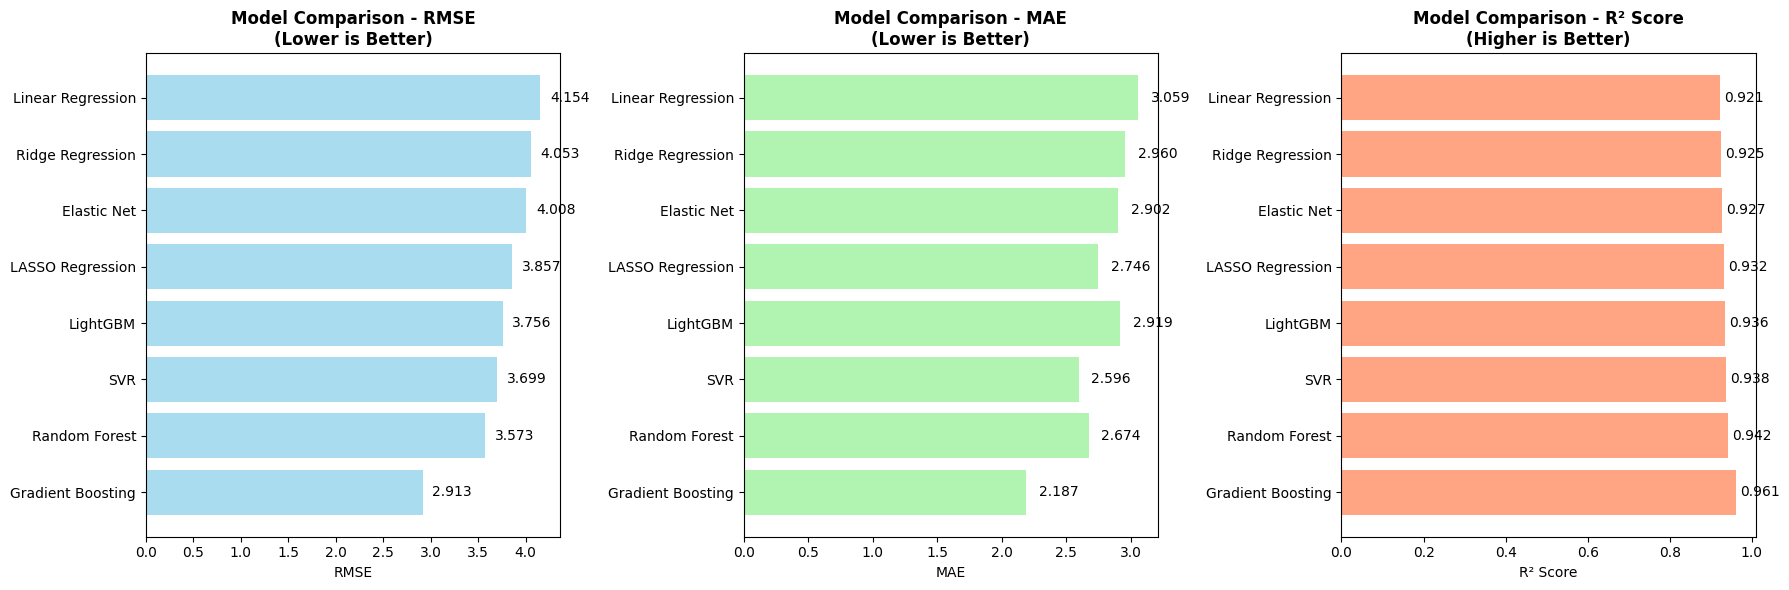

In [77]:
# Create performance comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Comparison
axes[0].barh(final_results_df['Model'], final_results_df['RMSE'], color='skyblue', alpha=0.7)
axes[0].set_title('Model Comparison - RMSE\n(Lower is Better)', fontweight='bold')
axes[0].set_xlabel('RMSE')
for i, v in enumerate(final_results_df['RMSE']):
    axes[0].text(v + 0.1, i, f'{v:.3f}', va='center')

# MAE Comparison
axes[1].barh(final_results_df['Model'], final_results_df['MAE'], color='lightgreen', alpha=0.7)
axes[1].set_title('Model Comparison - MAE\n(Lower is Better)', fontweight='bold')
axes[1].set_xlabel('MAE')
for i, v in enumerate(final_results_df['MAE']):
    axes[1].text(v + 0.1, i, f'{v:.3f}', va='center')

# R² Comparison
axes[2].barh(final_results_df['Model'], final_results_df['R2_Score'], color='coral', alpha=0.7)
axes[2].set_title('Model Comparison - R² Score\n(Higher is Better)', fontweight='bold')
axes[2].set_xlabel('R² Score')
for i, v in enumerate(final_results_df['R2_Score']):
    axes[2].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

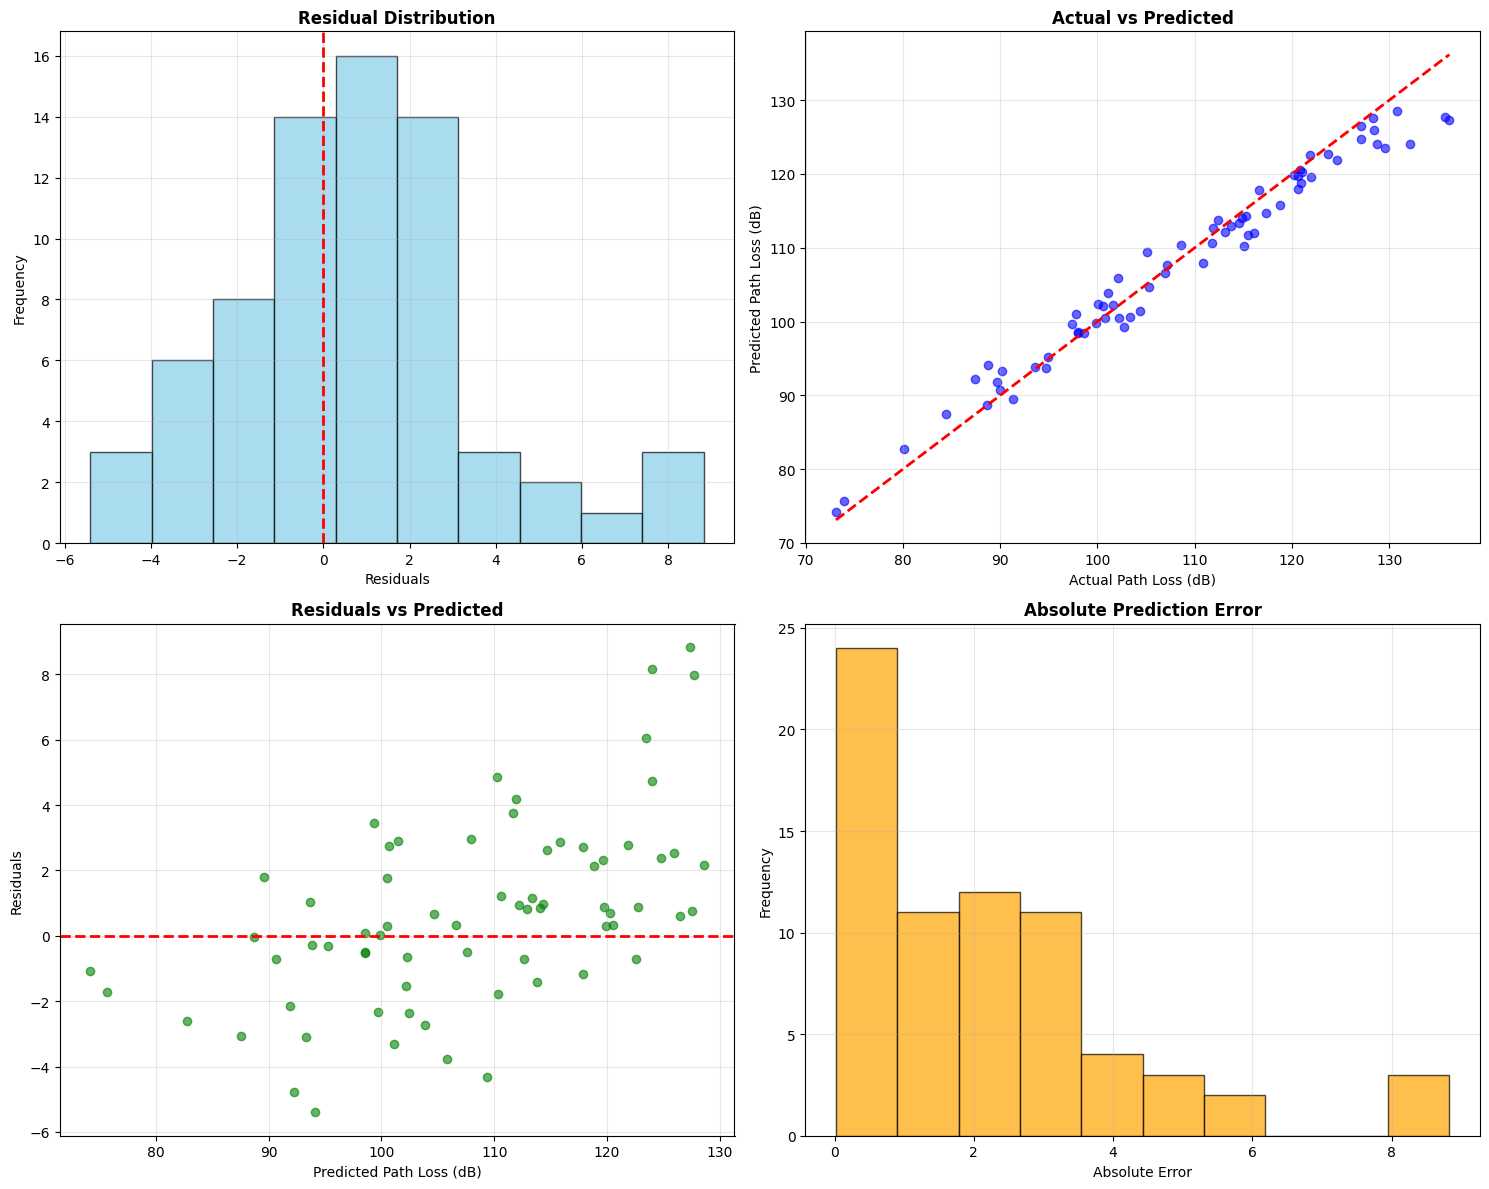

Error Analysis Statistics:
   Mean Residual: 0.6578
   Std of Residuals: 2.8585
   Mean Absolute Error: 2.1871
   Max Error: 8.8302


In [78]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test_processed)
residuals = y_test - y_pred_best

# Create comprehensive error analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residual Distribution
axes[0, 0].hist(residuals, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residual Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Residuals')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred_best, alpha=0.6, color='blue')
max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 1].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 1].set_xlabel('Actual Path Loss (dB)')
axes[0, 1].set_ylabel('Predicted Path Loss (dB)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Predicted
axes[1, 0].scatter(y_pred_best, residuals, alpha=0.6, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuals vs Predicted', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Path Loss (dB)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Absolute Prediction Error
error = np.abs(residuals)
axes[1, 1].hist(error, bins=10, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Absolute Prediction Error', fontweight='bold')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print("Error Analysis Statistics:")
print(f"   Mean Residual: {residuals.mean():.4f}")
print(f"   Std of Residuals: {residuals.std():.4f}")
print(f"   Mean Absolute Error: {error.mean():.4f}")
print(f"   Max Error: {error.max():.4f}")

In [82]:
# Save the best model
joblib.dump(best_model, 'artifacts/best_model.joblib')
print("Best model saved as 'artifacts/best_model.joblib'")

# Save feature info
feature_info = {
    'selected_features': selected_features,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features
}
joblib.dump(feature_info, 'artifacts/feature_info.joblib')
print("Feature information saved")

# Save final results
final_results_df.to_csv('artifacts/model_performance_results.csv', index=False)
print("Model performance results saved")

# Enhanced inference function
def predict_path_loss(input_data, model_path='artifacts/best_model.joblib', 
                     preprocessor_path='artifacts/preprocessor.joblib',
                     feature_info_path='artifacts/feature_info.joblib'):
    """
    Predict path loss for new input data with robust error handling
    """
    try:
        # Load artifacts
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
        feature_info = joblib.load(feature_info_path)
        
        # Convert input to DataFrame
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        elif isinstance(input_data, list):
            input_df = pd.DataFrame(input_data)
        else:
            input_df = input_data.copy()
        
        # Ensure timestamp is parsed
        if 'Timestamp' in input_df.columns:
            input_df['Timestamp'] = pd.to_datetime(input_df['Timestamp'], errors='coerce')
        
        # Apply feature engineering
        input_df = engineer_features(input_df)
        
        # Select features and handle missing ones
        missing_features = set(feature_info['selected_features']) - set(input_df.columns)
        if missing_features:
            print(f"Warning: Missing features {missing_features}, filling with defaults")
            for feature in missing_features:
                if feature in feature_info['numerical_features']:
                    input_df[feature] = 0.0
                else:
                    input_df[feature] = 'missing'
        
        X_input = input_df[feature_info['selected_features']]
        
        # Preprocess and predict
        X_processed = preprocessor.transform(X_input)
        X_processed = ensure_dense_and_clean(X_processed)
        
        predictions = model.predict(X_processed)
        
        return predictions
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Test inference
print("Testing inference function...")
sample_input = {
    'Timestamp': '2024-01-25 14:30:00',
    'Signal Strength (dBm)': -85.0,
    'SNR': 20.5,
    'Environment': 'urban',
    'Attenuation': 8.2,
    'Distance to Tower (km)': 3.5
}

prediction = predict_path_loss(sample_input)
if prediction is not None:
    print(f"Sample prediction successful!")
    print(f"Input Signal Strength: {sample_input['Signal Strength (dBm)']} dBm")
    print(f"Predicted Path Loss: {prediction[0]:.2f} dB")
    print(f"Estimated RX Power: {23 - prediction[0]:.2f} dBm")

print(f"\n🎯 PROJECT SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {best_model_metrics['RMSE']:.4f} dB")
print(f"Test MAE: {best_model_metrics['MAE']:.4f} dB")
print(f"Test R²: {best_model_metrics['R2_Score']:.4f}")

Best model saved as 'artifacts/best_model.joblib'
Feature information saved
Model performance results saved
Testing inference function...
✅ Feature engineering completed! Added 19 new features
Sample prediction successful!
Input Signal Strength: -85.0 dBm
Predicted Path Loss: 106.56 dB
Estimated RX Power: -83.56 dBm

🎯 PROJECT SUMMARY:
Best Model: Gradient Boosting
Test RMSE: 2.9133 dB
Test MAE: 2.1871 dB
Test R²: 0.9613


📊 Starting Comprehensive Time Series Analysis...


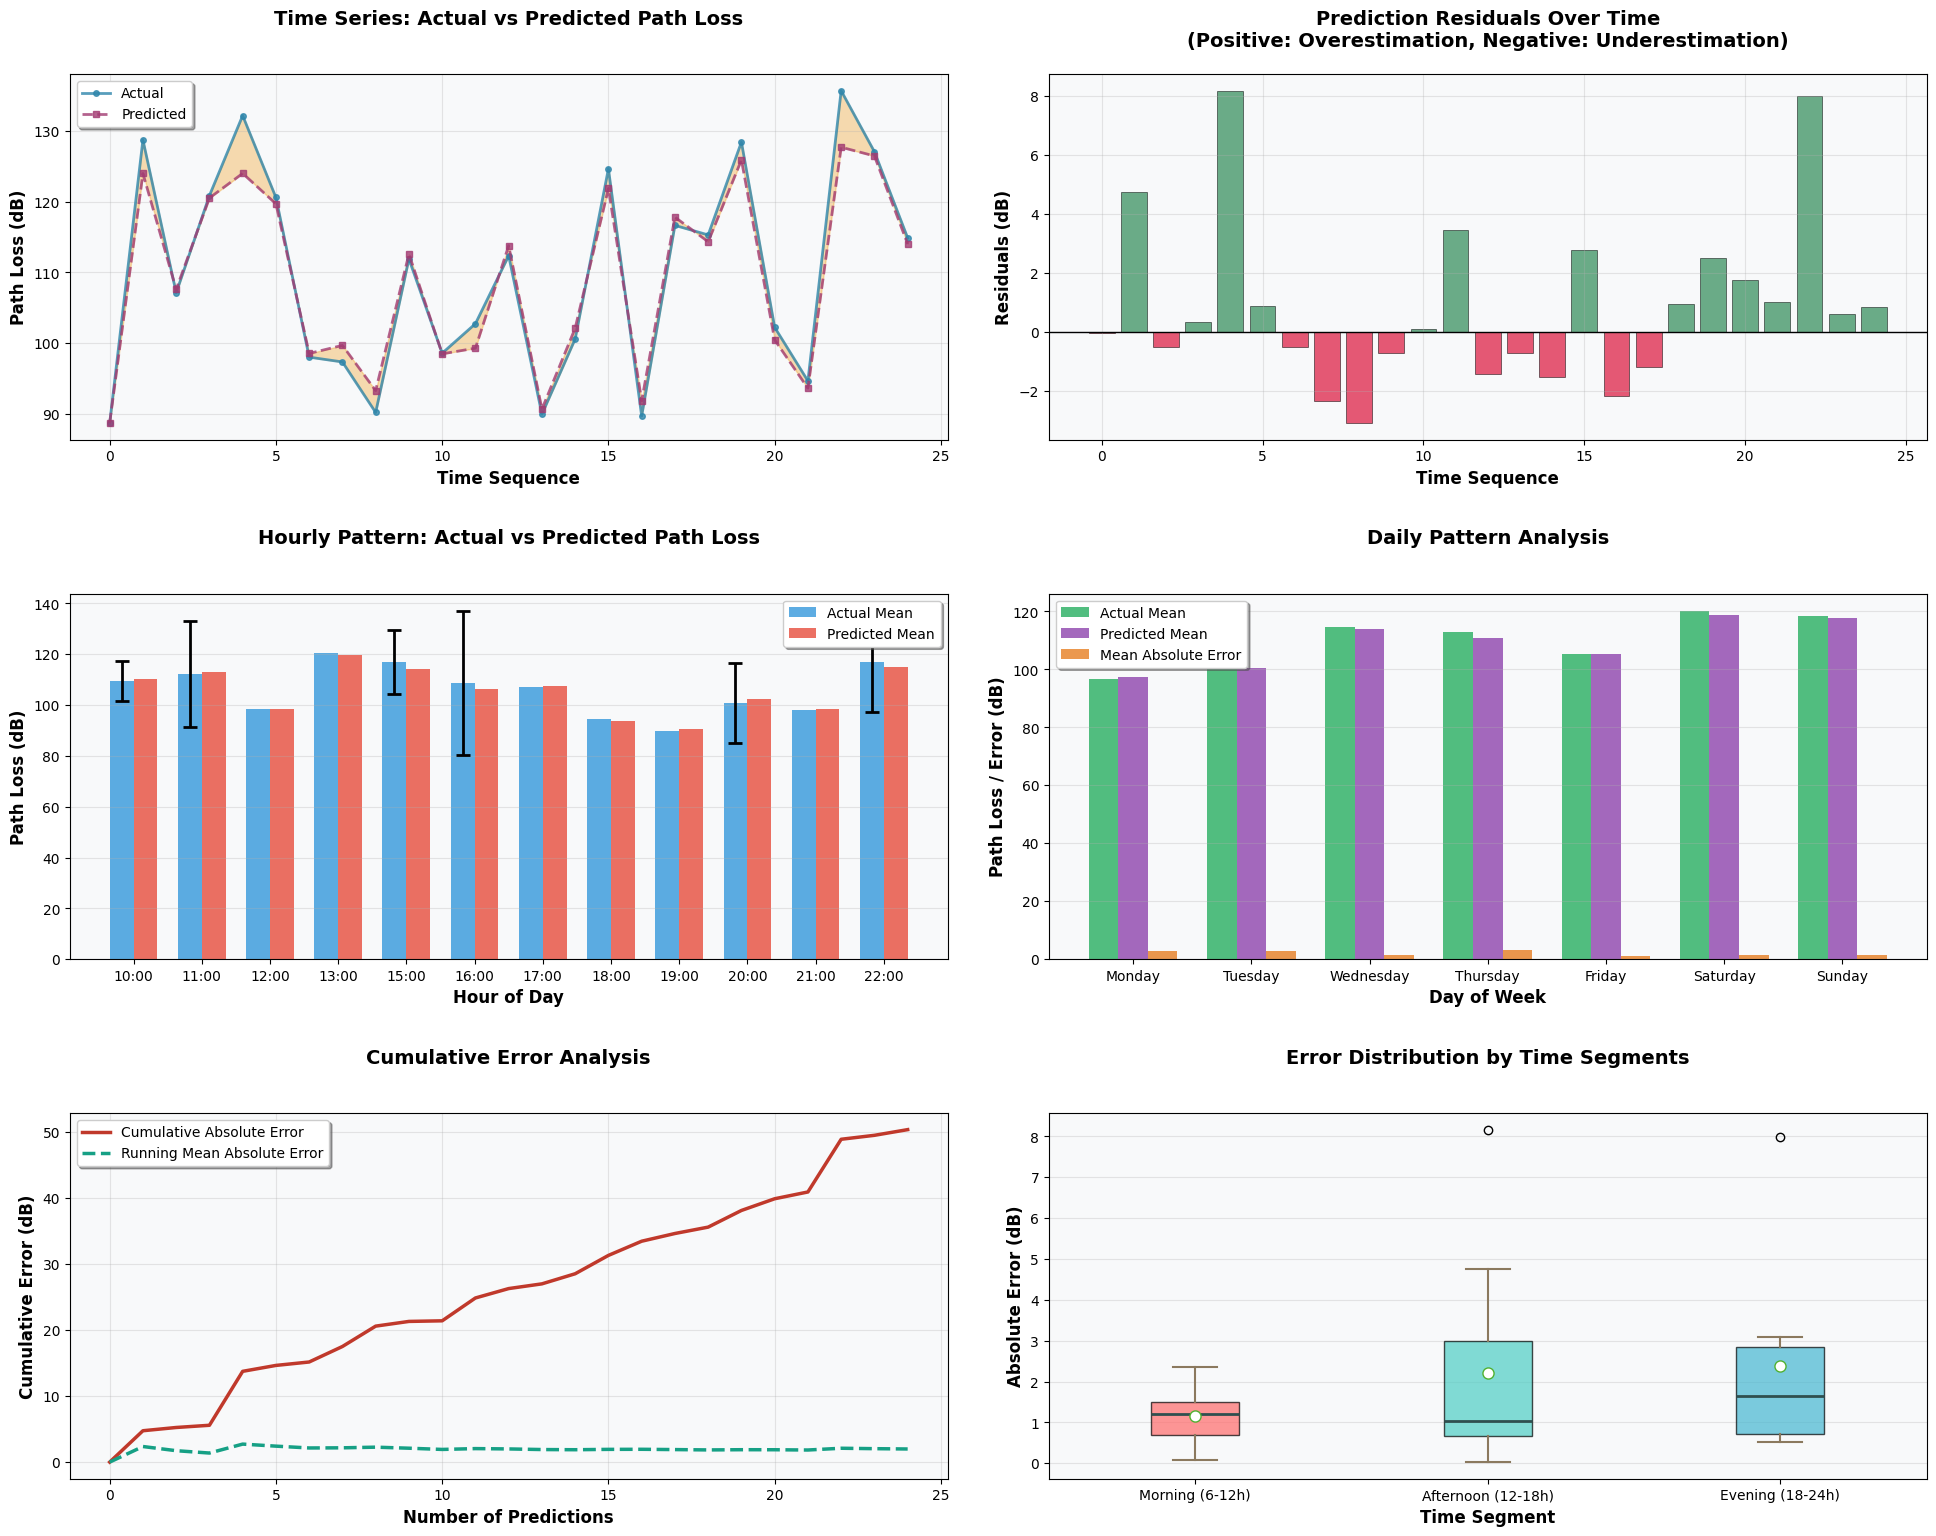


🕒 Time Segment Performance:
   • Most accurate: Morning (6-12h) (MAE: 1.159 dB)
   • Least accurate: Evening (18-24h) (MAE: 2.388 dB)
   • Best prediction accuracy: 12:00 (MAE: 0.091 dB)
   • Worst prediction accuracy: 22:00 (MAE: 3.753 dB)
📅 Daily Performance:
   • Most accurate day: Friday (MAE: 1.179 dB)
   • Least accurate day: Thursday (MAE: 3.350 dB)
🕒 Time Segment Performance:
   • Most accurate: Morning (6-12h) (MAE: 1.159 dB)
   • Least accurate: Night (0-6h) (MAE: nan dB)
📊 Model Stability:
   • Error trend: improving
   • Final running MAE: 2.015 dB
   • Total cumulative error: 50.371 dB

🔍 Advanced Temporal Patterns:
   • Peak error hours: 22:00, 15:00, 16:00
   • Most consistent predictions: 10:00 (std: 0.300)
   • Least consistent predictions: 16:00 (std: 3.336)
   • Maximum overestimation: 15:00 (2.853 dB)
   • Maximum underestimation: 20:00 (-1.430 dB)

✅ Temporal analysis completed successfully!


In [84]:
# Comprehensive Time Series Analysis
print("📊 Starting Comprehensive Time Series Analysis...")

# Create a copy of the test set with predictions and timestamps
test_results = X_test.copy()
test_results['Actual_Path_Loss'] = y_test.values
test_results['Predicted_Path_Loss'] = y_pred_best
test_results['Residuals'] = residuals
test_results['Absolute_Error'] = np.abs(residuals)

# Extract time components for analysis
test_results['Hour'] = test_results.index.map(lambda x: df_engineered.loc[x, 'hour'] if x in df_engineered.index else np.nan)
test_results['Day_of_Week'] = test_results.index.map(lambda x: df_engineered.loc[x, 'day_of_week'] if x in df_engineered.index else np.nan)
test_results['Timestamp'] = test_results.index.map(lambda x: df_engineered.loc[x, 'Timestamp'] if x in df_engineered.index else pd.NaT)

# Drop rows with missing timestamps
test_results = test_results.dropna(subset=['Timestamp'])
test_results = test_results.sort_values('Timestamp')

# Create comprehensive time analysis plots
fig = plt.figure(figsize=(20, 16))

# 1. Time Series of Actual vs Predicted
ax1 = plt.subplot(3, 2, 1)
time_points = range(len(test_results))
ax1.plot(time_points, test_results['Actual_Path_Loss'], 
         label='Actual', color='#2E86AB', linewidth=2, alpha=0.8, marker='o', markersize=4)
ax1.plot(time_points, test_results['Predicted_Path_Loss'], 
         label='Predicted', color='#A23B72', linewidth=2, alpha=0.8, linestyle='--', marker='s', markersize=4)
ax1.fill_between(time_points, 
                test_results['Actual_Path_Loss'], 
                test_results['Predicted_Path_Loss'],
                alpha=0.3, color='#F18F01')
ax1.set_title('Time Series: Actual vs Predicted Path Loss\n', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Time Sequence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Path Loss (dB)', fontsize=12, fontweight='bold')
ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f8f9fa')

# 2. Residuals Over Time
ax2 = plt.subplot(3, 2, 2)
residual_colors = ['#2E8B57' if x >= 0 else '#DC143C' for x in test_results['Residuals']]
bars = ax2.bar(time_points, test_results['Residuals'], color=residual_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Prediction Residuals Over Time\n(Positive: Overestimation, Negative: Underestimation)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Time Sequence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Residuals (dB)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')

# 3. Hourly Pattern Analysis
ax3 = plt.subplot(3, 2, 3)
hourly_stats = test_results.groupby('Hour').agg({
    'Actual_Path_Loss': ['mean', 'std'],
    'Predicted_Path_Loss': 'mean',
    'Absolute_Error': 'mean'
}).round(3)

hours = hourly_stats.index
actual_means = hourly_stats[('Actual_Path_Loss', 'mean')]
actual_stds = hourly_stats[('Actual_Path_Loss', 'std')]
predicted_means = hourly_stats[('Predicted_Path_Loss', 'mean')]
error_means = hourly_stats[('Absolute_Error', 'mean')]

# Create bar plot with error bars
bar_width = 0.35
x_pos = np.arange(len(hours))
bars1 = ax3.bar(x_pos - bar_width/2, actual_means, bar_width, 
                label='Actual Mean', color='#3498DB', alpha=0.8, yerr=actual_stds, 
                capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
bars2 = ax3.bar(x_pos + bar_width/2, predicted_means, bar_width, 
                label='Predicted Mean', color='#E74C3C', alpha=0.8)

ax3.set_title('Hourly Pattern: Actual vs Predicted Path Loss\n', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax3.set_ylabel('Path Loss (dB)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{int(h):02d}:00' for h in hours])
ax3.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_facecolor('#f8f9fa')

# 4. Daily Pattern Analysis
ax4 = plt.subplot(3, 2, 4)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_stats = test_results.groupby('Day_of_Week').agg({
    'Actual_Path_Loss': 'mean',
    'Predicted_Path_Loss': 'mean', 
    'Absolute_Error': 'mean'
}).round(3)

days = daily_stats.index
daily_actual = daily_stats['Actual_Path_Loss']
daily_predicted = daily_stats['Predicted_Path_Loss']
daily_error = daily_stats['Absolute_Error']

x_pos_daily = np.arange(len(days))
bars_actual = ax4.bar(x_pos_daily - 0.25, daily_actual, 0.25, 
                      label='Actual Mean', color='#27AE60', alpha=0.8)
bars_predicted = ax4.bar(x_pos_daily, daily_predicted, 0.25, 
                         label='Predicted Mean', color='#8E44AD', alpha=0.8)
bars_error = ax4.bar(x_pos_daily + 0.25, daily_error, 0.25, 
                     label='Mean Absolute Error', color='#E67E22', alpha=0.8)

ax4.set_title('Daily Pattern Analysis\n', fontsize=14, fontweight='bold', pad=20)
ax4.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax4.set_ylabel('Path Loss / Error (dB)', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos_daily)
ax4.set_xticklabels([day_names[int(d)] if d < len(day_names) else f'Day {int(d)}' for d in days])
ax4.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_facecolor('#f8f9fa')

# 5. Cumulative Error Analysis
ax5 = plt.subplot(3, 2, 5)
cumulative_error = test_results['Absolute_Error'].cumsum()
cumulative_mean_error = cumulative_error / (np.arange(len(cumulative_error)) + 1)

ax5.plot(time_points, cumulative_error, 
         label='Cumulative Absolute Error', color='#C0392B', linewidth=2.5)
ax5.plot(time_points, cumulative_mean_error, 
         label='Running Mean Absolute Error', color='#16A085', linewidth=2.5, linestyle='--')
ax5.set_title('Cumulative Error Analysis\n', fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Number of Predictions', fontsize=12, fontweight='bold')
ax5.set_ylabel('Cumulative Error (dB)', fontsize=12, fontweight='bold')
ax5.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax5.grid(True, alpha=0.3)
ax5.set_facecolor('#f8f9fa')

# 6. Error Distribution by Time Segments (robust to missing segments)
ax6 = plt.subplot(3, 2, 6)
segment_labels = ['Night (0-6h)', 'Morning (6-12h)', 'Afternoon (12-18h)', 'Evening (18-24h)']
time_segments = pd.cut(test_results['Hour'], bins=[0, 6, 12, 18, 24],
                       labels=segment_labels, include_lowest=True)
segment_errors = test_results.groupby(time_segments)['Absolute_Error']

# Build ordered list of non-empty segment groups
segment_data = []
segment_names = []
for seg in segment_labels:
    try:
        grp = segment_errors.get_group(seg)
        if grp.empty:
            continue
        segment_data.append(grp)
        segment_names.append(seg)
    except KeyError:
        # group does not exist (no observations in this segment)
        continue

if len(segment_data) == 0:
    # No data available for any segment: display message
    ax6.text(0.5, 0.5, 'No data for time-segment error distribution', ha='center', va='center', fontsize=12)
    ax6.set_axis_off()
else:
    box_plot = ax6.boxplot(segment_data, labels=segment_names,
                           patch_artist=True, showmeans=True,
                           meanprops={"marker": "o", "markerfacecolor": "white", "markersize": 8})

    # Customize boxplot colors (slice to match number of segments)
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    colors = base_colors[:len(segment_data)]
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    for whisker in box_plot.get('whiskers', []):
        whisker.set(color='#8B795E', linewidth=1.5)
    for cap in box_plot.get('caps', []):
        cap.set(color='#8B795E', linewidth=1.5)
    for median in box_plot.get('medians', []):
        median.set(color='#2F4F4F', linewidth=2)

ax6.set_title('Error Distribution by Time Segments\n', fontsize=14, fontweight='bold', pad=20)
ax6.set_xlabel('Time Segment', fontsize=12, fontweight='bold')
ax6.set_ylabel('Absolute Error (dB)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_facecolor('#f8f9fa')

plt.tight_layout(pad=3.0)
plt.show()

# Print temporal analysis insights
print("\n" + "="*80)
# Time segment insights (robust handling if some segments are empty)
segment_performance = test_results.groupby(time_segments)['Absolute_Error'].mean()
# ensure a consistent order and drop empty segments
segment_performance = segment_performance.reindex(segment_labels).dropna()

print(f"🕒 Time Segment Performance:")
if not segment_performance.empty:
    best_segment = segment_performance.idxmin()
    worst_segment = segment_performance.idxmax()
    print(f"   • Most accurate: {best_segment} (MAE: {segment_performance[best_segment]:.3f} dB)")
    print(f"   • Least accurate: {worst_segment} (MAE: {segment_performance[worst_segment]:.3f} dB)")
else:
    print("   • No time-segment error data available to compute performance.")

# Determine best/worst hours from hourly_stats (robust to different column layouts)
try:
    # hourly_stats may have MultiIndex columns: ('Absolute_Error','mean')
    if ('Absolute_Error', 'mean') in hourly_stats.columns:
        hour_errors = hourly_stats[('Absolute_Error', 'mean')].dropna()
    elif 'Absolute_Error' in hourly_stats.columns:
        hour_errors = hourly_stats['Absolute_Error'].dropna()
    else:
        # fallback: try to find any column that contains 'Absolute_Error'
        ae_cols = [c for c in hourly_stats.columns if isinstance(c, tuple) and c[0] == 'Absolute_Error']
        if ae_cols:
            hour_errors = hourly_stats[ae_cols[0]].dropna()
        else:
            hour_errors = pd.Series(dtype=float)

    if not hour_errors.empty:
        min_error_hour = hour_errors.idxmin()
        max_error_hour = hour_errors.idxmax()
        print(f"   • Best prediction accuracy: {int(min_error_hour):02d}:00 (MAE: {hour_errors[min_error_hour]:.3f} dB)")
        print(f"   • Worst prediction accuracy: {int(max_error_hour):02d}:00 (MAE: {hour_errors[max_error_hour]:.3f} dB)")
    else:
        print("   • No hourly error stats available to determine best/worst hours.")
except Exception as e:
    print(f"   • Unable to determine best/worst hours due to error: {e}")

# Daily insights
if 'Day_of_Week' in test_results.columns:
    best_day = daily_stats['Absolute_Error'].idxmin()
    worst_day = daily_stats['Absolute_Error'].idxmax()
    day_name = day_names[int(best_day)] if best_day < len(day_names) else f'Day {int(best_day)}'
    worst_day_name = day_names[int(worst_day)] if worst_day < len(day_names) else f'Day {int(worst_day)}'
    print(f"📅 Daily Performance:")
    print(f"   • Most accurate day: {day_name} (MAE: {daily_stats.loc[best_day, 'Absolute_Error']:.3f} dB)")
    print(f"   • Least accurate day: {worst_day_name} (MAE: {daily_stats.loc[worst_day, 'Absolute_Error']:.3f} dB)")

# Time segment insights
segment_performance = test_results.groupby(time_segments)['Absolute_Error'].mean().sort_values()
best_segment = segment_performance.index[0]
worst_segment = segment_performance.index[-1]
print(f"🕒 Time Segment Performance:")
print(f"   • Most accurate: {best_segment} (MAE: {segment_performance[best_segment]:.3f} dB)")
print(f"   • Least accurate: {worst_segment} (MAE: {segment_performance[worst_segment]:.3f} dB)")

# Model stability analysis
error_trend = "improving" if cumulative_mean_error.iloc[-1] < cumulative_mean_error.iloc[len(cumulative_mean_error)//2] else "stable" if abs(cumulative_mean_error.iloc[-1] - cumulative_mean_error.iloc[len(cumulative_mean_error)//2]) < 0.1 else "degrading"
print(f"📊 Model Stability:")
print(f"   • Error trend: {error_trend}")
print(f"   • Final running MAE: {cumulative_mean_error.iloc[-1]:.3f} dB")
print(f"   • Total cumulative error: {cumulative_error.iloc[-1]:.3f} dB")

print("="*80)

# Additional advanced time analysis
print("\n🔍 Advanced Temporal Patterns:")

# Peak error periods
high_error_periods = test_results[test_results['Absolute_Error'] > test_results['Absolute_Error'].quantile(0.75)]
if not high_error_periods.empty:
    peak_error_hours = high_error_periods['Hour'].value_counts().head(3)
    print("   • Peak error hours:", ", ".join([f"{int(hour):02d}:00" for hour in peak_error_hours.index]))

# Consistency analysis
hourly_consistency = test_results.groupby('Hour')['Absolute_Error'].std()
most_consistent_hour = hourly_consistency.idxmin()
least_consistent_hour = hourly_consistency.idxmax()
print(f"   • Most consistent predictions: {int(most_consistent_hour):02d}:00 (std: {hourly_consistency[most_consistent_hour]:.3f})")
print(f"   • Least consistent predictions: {int(least_consistent_hour):02d}:00 (std: {hourly_consistency[least_consistent_hour]:.3f})")

# Temporal bias analysis
temporal_bias = test_results.groupby('Hour')['Residuals'].mean()
max_overestimation_hour = temporal_bias.idxmax()
max_underestimation_hour = temporal_bias.idxmin()
print(f"   • Maximum overestimation: {int(max_overestimation_hour):02d}:00 ({temporal_bias[max_overestimation_hour]:.3f} dB)")
print(f"   • Maximum underestimation: {int(max_underestimation_hour):02d}:00 ({temporal_bias[max_underestimation_hour]:.3f} dB)")

print("\n✅ Temporal analysis completed successfully!")

📊 Generating A4-Optimized Process Flow Diagram...


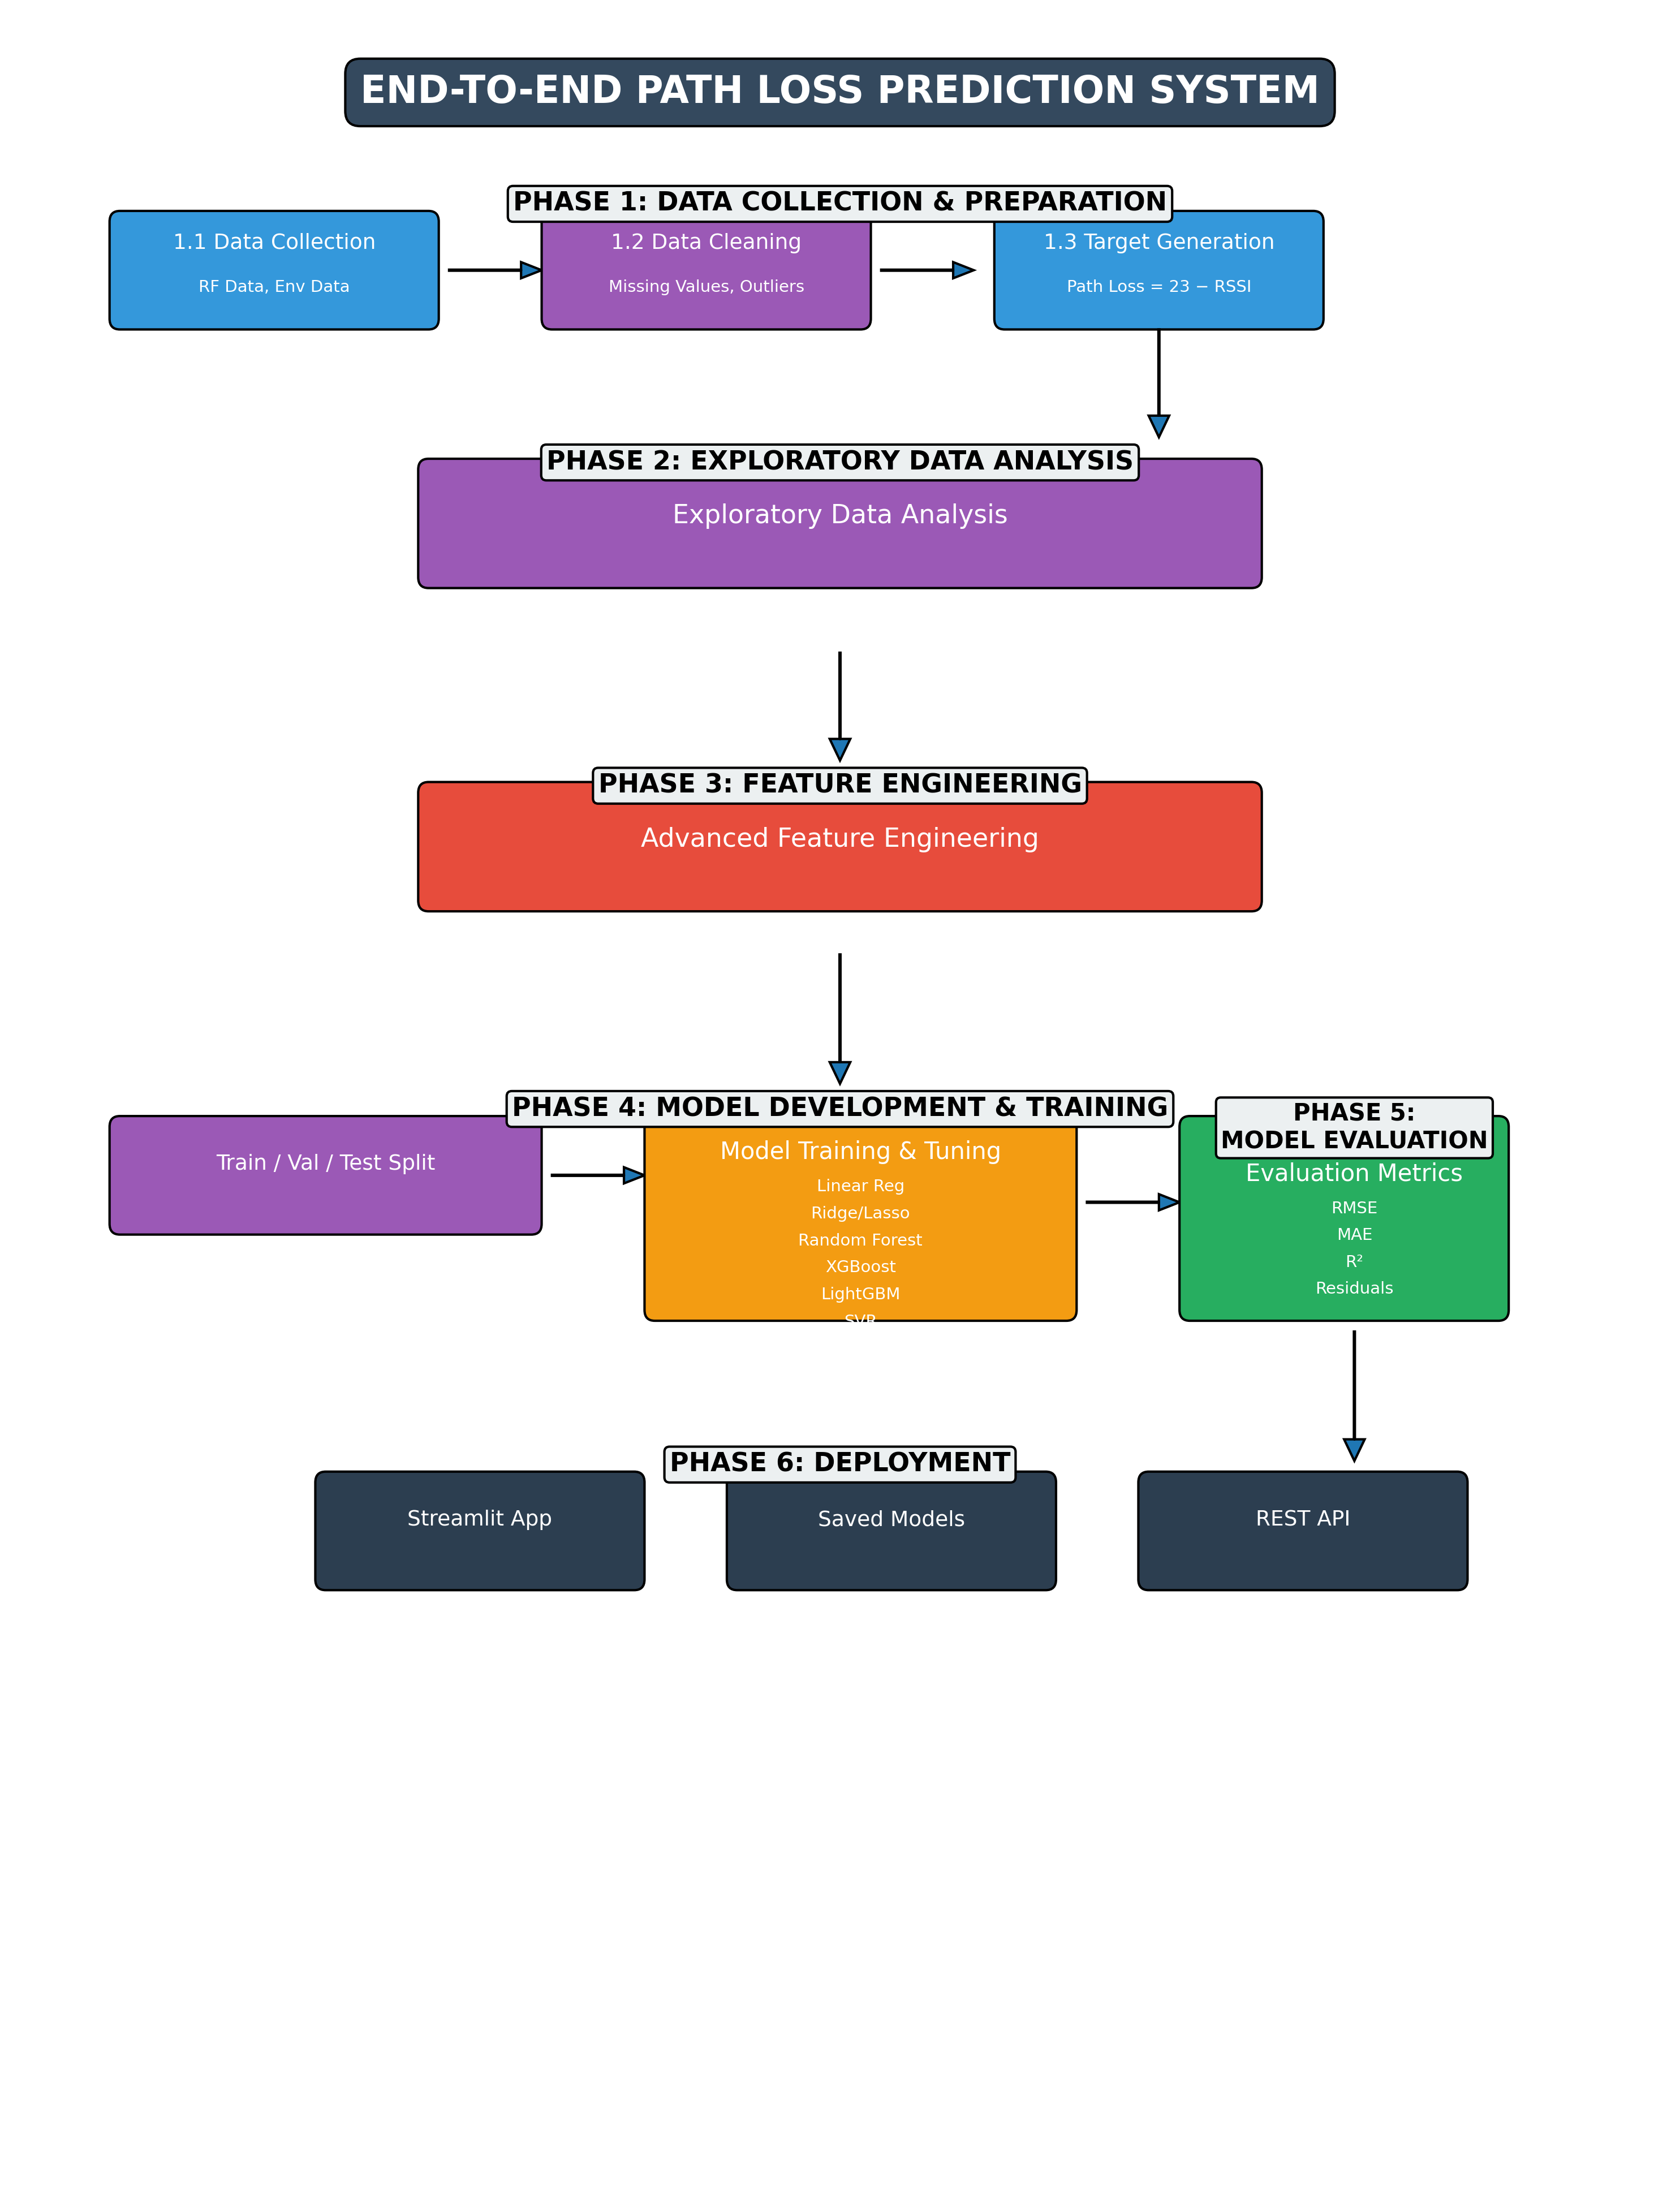

In [12]:
# ================= A4-OPTIMIZED PROCESS FLOW DIAGRAM ====================

print("📊 Generating A4-Optimized Process Flow Diagram...")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle

fig, ax = plt.subplots(figsize=(10, 13))   # A4 friendly 10x13 inches
ax.set_xlim(0, 16)
ax.set_ylim(0, 20)                         # Taller canvas (previously 12)
ax.axis('off')

# ----- COLOR PALETTE -----
colors = {
    'data': '#3498DB',
    'preprocessing': '#9B59B6',
    'feature_eng': '#E74C3C',
    'modeling': '#F39C12',
    'evaluation': '#27AE60',
    'deployment': '#2C3E50'
}

# ================= TITLE ==================
ax.text(8, 19.2, 'END-TO-END PATH LOSS PREDICTION SYSTEM',
        ha='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.4", facecolor='#34495E', edgecolor='black'),
        color='white')

# ================= PHASE 1 =================
ax.text(8, 18.2, 'PHASE 1: DATA COLLECTION & PREPARATION',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

# 1.1 Data Collection
ax.add_patch(FancyBboxPatch((1, 17.2), 3, 0.9, boxstyle="round,pad=0.1",
                            facecolor=colors['data'], edgecolor='black'))
ax.text(2.5, 17.85, '1.1 Data Collection', ha='center', fontsize=9, color='white')
ax.text(2.5, 17.45, 'RF Data, Env Data', ha='center', fontsize=7, color='white')

ax.arrow(4.2, 17.65, 0.7, 0, width=0.01, head_width=0.15, head_length=0.2)

# 1.2 Data Cleaning
ax.add_patch(FancyBboxPatch((5.2, 17.2), 3, 0.9, boxstyle="round,pad=0.1",
                            facecolor=colors['preprocessing'], edgecolor='black'))
ax.text(6.7, 17.85, '1.2 Data Cleaning', ha='center', fontsize=9, color='white')
ax.text(6.7, 17.45, 'Missing Values, Outliers', ha='center', fontsize=7, color='white')

ax.arrow(8.4, 17.65, 0.7, 0, width=0.01, head_width=0.15, head_length=0.2)

# 1.3 Target Generation
ax.add_patch(FancyBboxPatch((9.6, 17.2), 3, 0.9, boxstyle="round,pad=0.1",
                            facecolor=colors['data'], edgecolor='black'))
ax.text(11.1, 17.85, '1.3 Target Generation', ha='center', fontsize=9, color='white')
ax.text(11.1, 17.45, 'Path Loss = 23 − RSSI', ha='center', fontsize=7, color='white')

# Down arrow
ax.arrow(11.1, 17.1, 0, -0.8, width=0.01, head_width=0.2, head_length=0.2)

# ================= PHASE 2 =================
ax.text(8, 15.8, 'PHASE 2: EXPLORATORY DATA ANALYSIS',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

# EDA Box
ax.add_patch(FancyBboxPatch((4, 14.8), 8, 1.0, boxstyle="round,pad=0.1",
                            facecolor=colors['preprocessing'], edgecolor='black'))
ax.text(8, 15.3, 'Exploratory Data Analysis', ha='center', fontsize=11, color='white')

eda_components = [
    (5, 14.3, 'Distribution'),
    (6.5, 14.3, 'Correlation'),
    (8, 14.3, 'Time-Series'),
    (9.5, 14.3, 'Feature Impact'),
    (11, 14.3, 'Stats Summary')
]

for x, y, text in eda_components:
    ax.text(x, y, text, ha='center', fontsize=7, color='white')

# Down arrow
ax.arrow(8, 14.1, 0, -0.8, width=0.01, head_width=0.2, head_length=0.2)

# ================= PHASE 3 =================
ax.text(8, 12.8, 'PHASE 3: FEATURE ENGINEERING',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

ax.add_patch(FancyBboxPatch((4, 11.8), 8, 1.0, boxstyle="round,pad=0.1",
                            facecolor=colors['feature_eng'], edgecolor='black'))
ax.text(8, 12.3, 'Advanced Feature Engineering', ha='center', fontsize=11, color='white')

fe_list = ['Time Features', 'Transforms', 'Interactions', 'Encoding', 'Feature Selection']
for i, text in enumerate(fe_list):
    ax.text(5 + i*1.5, 11.4, text, ha='center', fontsize=7, color='white')

ax.arrow(8, 11.3, 0, -1.0, width=0.01, head_width=0.2, head_length=0.2)

# ================= PHASE 4 =================
ax.text(8, 9.8, 'PHASE 4: MODEL DEVELOPMENT & TRAINING',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

# Data Splitting
ax.add_patch(FancyBboxPatch((1, 8.8), 4, 0.9, boxstyle="round,pad=0.1",
                            facecolor=colors['preprocessing'], edgecolor='black'))
ax.text(3, 9.3, 'Train / Val / Test Split', ha='center', fontsize=9, color='white')

# Arrow
ax.arrow(5.2, 9.25, 0.7, 0, width=0.01, head_width=0.15, head_length=0.2)

# Model Training Block
ax.add_patch(FancyBboxPatch((6.2, 8.0), 4, 1.7, boxstyle="round,pad=0.1",
                            facecolor=colors['modeling'], edgecolor='black'))
ax.text(8.2, 9.4, 'Model Training & Tuning', ha='center', fontsize=10, color='white')

models_list = ['Linear Reg', 'Ridge/Lasso', 'Random Forest', 'XGBoost', 'LightGBM', 'SVR']
for i, text in enumerate(models_list):
    ax.text(8.2, 9.1 - i*0.25, text, ha='center', fontsize=7, color='white')

# Arrow
ax.arrow(10.4, 9, 0.7, 0, width=0.01, head_width=0.15, head_length=0.2)

# ================= PHASE 5 =================
ax.text(13, 9.5, 'PHASE 5:\nMODEL EVALUATION',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

ax.add_patch(FancyBboxPatch((11.4, 8.0), 3, 1.7, boxstyle="round,pad=0.1",
                            facecolor=colors['evaluation'], edgecolor='black'))
ax.text(13, 9.2, 'Evaluation Metrics', ha='center', fontsize=10, color='white')

metrics = ['RMSE', 'MAE', 'R²', 'Residuals']
for i, text in enumerate(metrics):
    ax.text(13, 8.9 - i*0.25, text, ha='center', fontsize=7, color='white')

ax.arrow(13, 7.8, 0, -1.0, width=0.01, head_width=0.2, head_length=0.2)

# ================= PHASE 6 =================
ax.text(8, 6.5, 'PHASE 6: DEPLOYMENT',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ECF0F1'))

deploy_items = ['Streamlit App', 'Saved Models', 'REST API']
for i, text in enumerate(deploy_items):
    ax.add_patch(FancyBboxPatch((3 + i*4, 5.5), 3, 0.9, boxstyle="round,pad=0.1",
                                facecolor=colors['deployment'], edgecolor='black'))
    ax.text(4.5 + i*4, 6.0, text, ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig("process_flow_diagram.svg", format="svg", dpi=300, bbox_inches="tight")
plt.show()